In [7]:
# Import basic data science packages
import numpy as np

# Import tensorflow packages
import tensorflow as tf
from tensorflow.test import gpu_device_name

# Import various keras tools
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
device_name = gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
# Mount Google Drive
from google.colab import drive # import drive from google colab

ROOT = "/content/drive"     # default location for the drive
print(ROOT)                 # print content of ROOT (Optional)

drive.mount(ROOT)           # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/BrainStation\ Capstone\ Project/capstone

/content/drive/MyDrive/BrainStation Capstone Project/capstone


In [5]:
#import pcamlib to Google Colab
import imp 
pcamlib = imp.new_module('pcamlib')
exec(open("./pcamlib.py").read(), pcamlib.__dict__)

In [6]:
pcam, pcam_info = pcamlib.load_pcam()

Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteWE5DPH/patch_camelyon-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteWE5DPH/patch_camelyon-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/patch_camelyon/2.0.0.incompleteWE5DPH/patch_camelyon-validation.tfrecord


Dataset patch_camelyon downloaded and prepared to /root/tensorflow_datasets/patch_camelyon/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
      

In [8]:
train_pipeline, valid_pipeline, test_pipeline = pcamlib.build_pipelines(pcam)

In [18]:
resnet50 = ResNet50V2(weights='imagenet',
                   include_top=False,
                   input_shape=(96,96,3))
# resnet50.summary()

In [19]:
# Freeze all the layers in the base model
for layer in resnet50.layers:
    layer.trainable = False

In [20]:
# Add our own layers to the end of the network
x = resnet50.output 
x = Flatten()(x) 
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# Did not work well with 128, 64 for dense layers

# Add the last layer of 2 outputs for the binary image classification task
output = Dense(2, activation='softmax')(x)

resnet50 = Model(inputs=resnet50.input, 
              outputs=output)

In [13]:
resnet50.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 102, 102, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 48, 48, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 50, 50, 64)   0           conv1_conv[0][0]                 
______________________________________________________________________________________________

In [23]:
# Changed from default 0.001
optimizer = Adam(learning_rate=0.01)

resnet50.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Use an early stopping callback to stop training once we no longer have improvements in our validation loss
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=3, 
                           mode='min', 
                           verbose=1)

In [24]:
%%time
history = resnet50.fit(train_pipeline,
          epochs=30,
          validation_data = valid_pipeline,
          steps_per_epoch=4096, 
          validation_steps=256,
          callbacks=[early_stop])

Epoch 1/30
4096/4096 [==============================] - 258s 62ms/step - loss: 0.4469 - accuracy: 0.8062 - val_loss: 0.4348 - val_accuracy: 0.8022
Epoch 2/30
4096/4096 [==============================] - 250s 61ms/step - loss: 0.4276 - accuracy: 0.8112 - val_loss: 0.6118 - val_accuracy: 0.8068
Epoch 3/30
4096/4096 [==============================] - 249s 61ms/step - loss: 0.4076 - accuracy: 0.8207 - val_loss: 0.4727 - val_accuracy: 0.8130
Epoch 4/30
4096/4096 [==============================] - 260s 63ms/step - loss: 0.3906 - accuracy: 0.8240 - val_loss: 0.4152 - val_accuracy: 0.8071
Epoch 5/30
4096/4096 [==============================] - 255s 62ms/step - loss: 0.3960 - accuracy: 0.8237 - val_loss: 0.4348 - val_accuracy: 0.7906
Epoch 6/30
4096/4096 [==============================] - 257s 63ms/step - loss: 0.3743 - accuracy: 0.8307 - val_loss: 0.4705 - val_accuracy: 0.7756
Epoch 7/30
4096/4096 [==============================] - 255s 62ms/step - loss: 0.3664 - accuracy: 0.8305 - val_loss: 0

In [25]:
# Save the fitted model to a file
resnet50.save('data/models/resnet50')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: data/models/resnet50/assets


INFO:tensorflow:Assets written to: data/models/resnet50/assets


In [26]:
# Save the history of the model to a csv
pcamlib.save_history(history, 'data/models/history/resnet50_history.csv')

In [28]:
# Uncomment the line below to load the model from file if necessary
# resnet50 = tf.keras.models.load_model("resnet50")
hist_df = pcamlib.load_history('data/models/history/resnet50_history.csv')

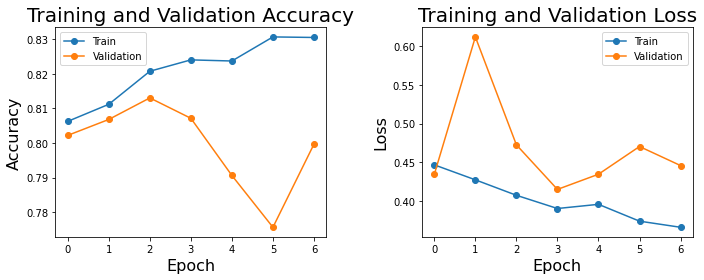

In [29]:
pcamlib.plot_history(hist_df)

In [30]:
%%time
pcamlib.print_test_accuracy(resnet50, test_pipeline)

Test set accuracy is 0.7817
CPU times: user 13 s, sys: 1.55 s, total: 14.6 s
Wall time: 20.5 s


In [31]:
%%time
y_proba = pcamlib.generate_y_proba(resnet50, test_pipeline, class_1=False, save=True, filepath='data/y_proba/resnet50_y_proba.csv')

CPU times: user 26.8 s, sys: 2.78 s, total: 29.6 s
Wall time: 19.7 s


In [ ]:
# Uncomment to load y_proba from file if not running the model
# y_proba = pcamlib.load_y_proba('data/y_proba/resnet50_proba.csv')
# y_proba

In [32]:
%%time
y_pred = pcamlib.generate_y_pred(y_proba)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.8 ms


In [33]:
%%time
y_true = pcamlib.generate_y_true(pcam)

CPU times: user 25.2 s, sys: 2.23 s, total: 27.4 s
Wall time: 14.7 s


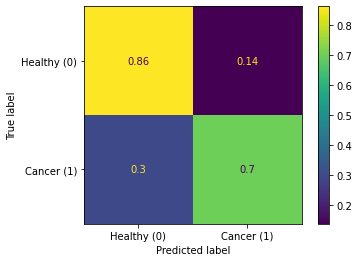

In [34]:
pcamlib.plot_cf_matrix(y_true, y_pred, normalize=True)

In [35]:
pcamlib.print_classification_report(y_true, y_pred)

              precision    recall  f1-score   support

           0     0.7432    0.8613    0.7979     16391
           1     0.8349    0.7022    0.7628     16377

    accuracy                         0.7818     32768
   macro avg     0.7891    0.7817    0.7804     32768
weighted avg     0.7891    0.7818    0.7804     32768



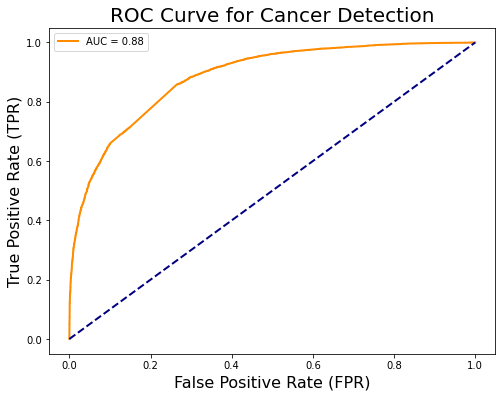

Area under curve (AUC):0.883782082443394
(7869,)
(7869,)


In [36]:
pcamlib.plot_roc_curve(y_true, y_proba)

0
4
10
12
15
16
20
24
25


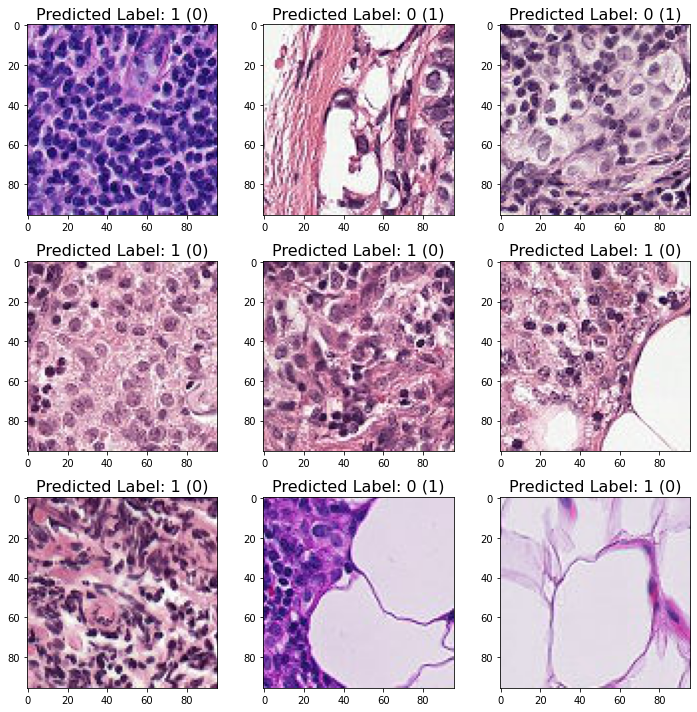

In [37]:
pcamlib.plot_misclassified_images(pcam, y_true, y_pred)